# Frame Reliability

In [1]:
import warnings
import numpy as np
import anon
anon.conf.config.update("jax_enable_x64", True)
import anabel.backend as anp
import matplotlib.pyplot as plt
import scipy.stats
import aleatoire, anabel
from aleatoire import biMorgen, siSet,rvSet, rvFunction, nataf, FORM

In [2]:
from simple_portal import f
f(6.,60.)

34383.789473684206


DeviceArray([[ 1.52848872],
             [ 0.00583991],
             [-0.01110097],
             [ 1.49259311],
             [-0.02807217],
             [ 0.0053456 ],
             [ 1.45669751],
             [-0.00603251],
             [-0.01047929]], dtype=float64)

In [3]:
res = 100
rng = 2

### Random variables


In [4]:
mean1, std1 = 6., 0.6
s = np.sqrt(np.log(std1**2/mean1**2+1))
mu = mean1**2/np.sqrt(std1**2+mean1**2)
X1 = scipy.stats.lognorm(s=s, scale=mu)
x1 = np.linspace(5,mean1+rng*std1,res)

In [5]:
mean2, std2 = 60., 6.
s2 = np.sqrt(np.log(std2**2/mean2**2+1))
m2 = mean2**2/np.sqrt(std2**2+mean2**2)
X2 = scipy.stats.lognorm(s=s2, scale=m2)
x2 = np.linspace(5,mean2+rng*std2,res)

In [6]:
print(X1.mean(),' ',X1.std())
print(X2.mean(),' ',X2.std())

6.0   0.6000000000000003
60.0   6.000000000000003


In [7]:
rho= 0.0
Rxx  = np.array([[1, rho],[rho,1]])
_xx_ = rvSet(rvars=[X1,X2],Rxx=Rxx)

### Limit State

In [8]:
def func_x(x):
    t,b = x
    return 1.6 - f(t,b).flatten()[0]

df = anabel.autodiff.jacfwd(func_x)

def grad_x(x):
    uh = df(x)
    return uh

## Part a)

### i) Statistically Independent

In [9]:
XYi = siSet([X1,X2])
pi = FORM(XYi,func_x,grad_x)
pi.run()
pi.print_analysis()

/home/claudio/pkgs/aleatoire/src/aleatoire/form.py:49: OptimizeWarning: Unknown solver options: tol, constr
  sol = minimize(f,u0, constraints=con, options=options)




FORM Results:
u*:    [-1.389 -0.76 ]
x*:    [ 5.198 55.346]
alpha: [-0.8774 -0.4798]
beta:  1.5831
pf1:   0.0567


### ii) Nataf

In [10]:
rho = 0.5
Rxx  = np.array([[1, rho],[rho,1]])
C = aleatoire.transform.nataf_correlation["lognorm"]["lognorm"]

XYii = nataf([X1,X2], Rxx, C)
pii = FORM(XYii,func_x,grad_x)
pii.run()
pii.print_analysis()

/home/claudio/pkgs/aleatoire/src/aleatoire/form.py:49: OptimizeWarning: Unknown solver options: tol, constr
  sol = minimize(f,u0, constraints=con, options=options)




FORM Results:
u*:    [-1.245 -0.461]
x*:    [ 5.273 53.909]
alpha: [-0.9377 -0.3475]
beta:  1.3277
pf1:   0.092135


## Part b) 

In [13]:
u1 = u2 = anp.linspace(-2,2,100)

In [14]:
def gsolve(x):
    f = lambda y: func_x([x,y[0]])
    return scipy.optimize.fsolve(f,0)[0]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gi = [gsolve(x) for x in x1]

def Gsolve(u1):
    f = lambda u2: func_x(XYii.u_to_x([u1,u2[0]]))
    return scipy.optimize.fsolve(f,0.001)[0]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Gi = [Gsolve(x) for x in u1]

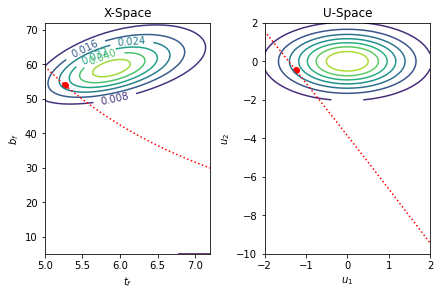

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,constrained_layout=True)

xx,yy = np.meshgrid(x1,x2)
zz = XYii.jpdf(xx,yy)
CS = ax1.contour(xx,yy,zz)#, extent=(x1[0], x1[-1], x2[0], x2[-1]))
ax1.clabel(CS, inline=1, fontsize=10)
ax1.scatter(*pii.design_point_x,color='red')
ax1.set_title('X-Space')
ax1.set_xlabel("$t_f$")
ax1.set_ylabel("$b_f$")
ax1.plot(x1,gi, 'r:')

uu,vv = np.meshgrid(u1, u2)
pos = np.empty(uu.shape + (2,))
pos[:, :, 0] = uu
pos[:, :, 1] = vv
        
oo = scipy.stats.multivariate_normal.pdf(pos, np.zeros(2))
CS = ax2.contour(uu,vv,oo)
ax2.scatter(*pii.design_point_u, color='red')
ax2.set_title('U-Space');
ax2.set_xlabel("$u_1$")
ax2.set_ylabel("$u_2$")
ax2.plot(u1,Gi, 'r:');